In [1]:
import tensorflow as tf
import sys
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
import pandas as pd
import numpy as np

file_path = "Data\Data.xlsx"

df = pd.read_excel(file_path)
df

,Unnamed: 0,Sentence,Label
0,0,"Afterhaving applied, 142 women completed the p...",N-Value
1,1,In a variation on Pennebakers writing paradigm...,N-Value
2,2,"Findings from a randomized, wait-list control ...",N-Value
3,3,In addition to the Clinical Interview for\nDep...,N-Value
4,4,Ninety-six\nparticipants were assigned to the ...,N-Value
...,...,...,...
367,367,we plan to incorporate such signals in future ...,Non_N-Value
368,368,the semantic textual similarity is a core prob...,Non_N-Value
369,369,based on this semi-supervised boosting algorit...,Non_N-Value
370,370,phrase structure trees in ctb have been semiau...,Non_N-Value


In [7]:
label_mapping = {'Non_N-Value': 0, 'N-Value': 1}
df['Label'] = df['Label'].replace(label_mapping)
df

,Unnamed: 0,Sentence,Label
0,0,"Afterhaving applied, 142 women completed the p...",1
1,1,In a variation on Pennebakers writing paradigm...,1
2,2,"Findings from a randomized, wait-list control ...",1
3,3,In addition to the Clinical Interview for\nDep...,1
4,4,Ninety-six\nparticipants were assigned to the ...,1
...,...,...,...
367,367,we plan to incorporate such signals in future ...,0
368,368,the semantic textual similarity is a core prob...,0
369,369,based on this semi-supervised boosting algorit...,0
370,370,phrase structure trees in ctb have been semiau...,0


In [8]:
print('Positive samples: %d of %d (%.2f%%)' % (df.Label.sum(), len(df.Label), (df.Label.sum() / len(df.Label) * 100.0)))

Positive samples: 186 of 372 (50.00%)


In [9]:
# Get the lists of sentences and their labels.
sentences = df['Sentence'].values
labels = df['Label'].values

In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)
model = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [11]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Afterhaving applied, 142 women completed the pre-test(T0) questionnaire, after which they were randomlyassigned to either the intervention group (n=63)or the control group (n=79).
Tokenized:  ['after', '##havi', '##ng', 'applied', ',', '142', 'women', 'completed', 'the', 'pre', '-', 'test', '(', 't', '##0', ')', 'questionnaire', ',', 'after', 'which', 'they', 'were', 'randomly', '##assi', '##gn', '##ed', 'to', 'either', 'the', 'intervention', 'group', '(', 'n', '=', '63', ')', 'or', 'the', 'control', 'group', '(', 'n', '=', '79', ')', '.']
Token IDs:  [647, 16159, 5733, 1765, 422, 19845, 2007, 5343, 111, 382, 579, 856, 145, 105, 30131, 546, 5692, 422, 647, 334, 698, 267, 5007, 6930, 3069, 119, 147, 1676, 111, 3832, 583, 145, 146, 275, 6729, 546, 234, 111, 602, 583, 145, 146, 275, 8455, 546, 205]


In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Afterhaving applied, 142 women completed the pre-test(T0) questionnaire, after which they were randomlyassigned to either the intervention group (n=63)or the control group (n=79).
Token IDs: [102, 647, 16159, 5733, 1765, 422, 19845, 2007, 5343, 111, 382, 579, 856, 145, 105, 30131, 546, 5692, 422, 647, 334, 698, 267, 5007, 6930, 3069, 119, 147, 1676, 111, 3832, 583, 145, 146, 275, 6729, 546, 234, 111, 602, 583, 145, 146, 275, 8455, 546, 205, 103]


In [13]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  130


In [14]:
average_length = sum(len(sen) for sen in input_ids) / len(input_ids)
print('Average sentence length:',average_length)

Average sentence length: 34.52956989247312


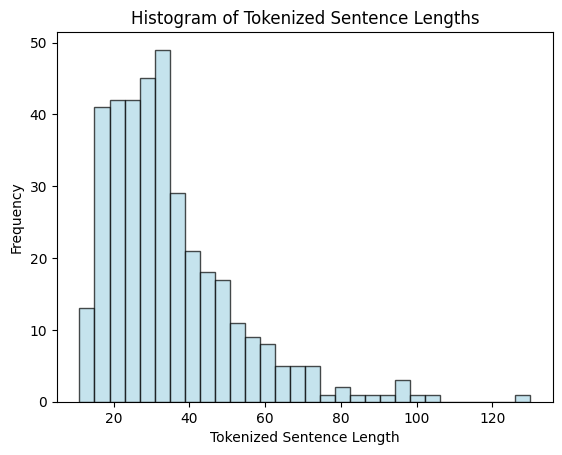

In [15]:
import matplotlib.pyplot as plt

# Calculate the lengths of tokenized sentences
sentence_lengths = [len(sen) for sen in input_ids]

# Create a histogram
plt.hist(sentence_lengths, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Tokenized Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Tokenized Sentence Lengths')
plt.show()

In [16]:
cutoff_length = 100

# Count the number of sentences below the cutoff
sentences_below_cutoff = sum(1 for length in sentence_lengths if length < cutoff_length)

print(f'Number of sentences below {cutoff_length} tokens: {sentences_below_cutoff}')

Number of sentences below 100 tokens: 369


In [17]:
cutoff_length = 100

# Find the sentences above the cutoff
long_sentences = [sentences[i] for i, length in enumerate(sentence_lengths) if length >= cutoff_length]

# Print the long sentences with a line space between each
for idx, long_sentence in enumerate(long_sentences):
    print(f'Sentence {idx + 1} (Length: {len(long_sentence)}):\n{long_sentence}\n')

Sentence 1 (Length: 520):
Thirty outpatients with a diagnosis of schizophrenia or schizoaffective disorder, and twenty-five healthy controls completed a well-validated facial affect processing task (Ekman 60-faces facial task from the Facial Expressions of Emotion - Stimuli and Tests; FEEST), The Awareness of Social Inference Test (TASIT; to assess emotion perception and complex social cognitive skills such as the detection of sarcasm and deceit, from realistic social exchanges), and measures of self-reported empathy and social functioning.

Sentence 2 (Length: 450):
Participants were 40 outpatients who met criteria for schizophrenia (n _x0001_ 30) or schizoaffective disorder (n _x0001_ 10) according to
the Diagnostic and Statistical Manual of Mental Disorders (4th ed.; DSM–IV; American Psychiatric Association, 1994) and 40 community volunteers as controls, matched to the individuals with schizophrenia on age, gender, race, handedness (all participants were right-handed), and parental 

In [18]:
#Pad sentences to max length
from keras.utils import pad_sequences

MAX_LEN = 100

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [19]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [20]:
# # We will call the train_test_split() function from sklearn
# from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

# Split into training and temporary (remaining) data
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels, 
                                                                        random_state=2018, test_size=0.3)

# Further split the remaining data into validation and test sets
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_inputs, temp_labels,
                                                                                  random_state=2018, test_size=0.5)

# Repeat the same steps for attention masks
train_masks, temp_masks, _, _ = train_test_split(attention_masks, labels,
                                                random_state=2018, test_size=0.3)
validation_masks, test_masks, _, _ = train_test_split(temp_masks, temp_labels,
                                                      random_state=2018, test_size=0.5)

In [21]:
import numpy as np

# Count the labels in each set
train_label_counts = np.bincount(train_labels)
validation_label_counts = np.bincount(validation_labels)
test_label_counts = np.bincount(test_labels)

# Print the counts
print("Train label counts:", train_label_counts)
print("Validation label counts:", validation_label_counts)
print("Test label counts:", test_label_counts)


Train label counts: [136 124]
Validation label counts: [25 31]
Test label counts: [25 31]


In [22]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4)


# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import BertForSequenceClassification, BertTokenizer

# Specify the SciBERT model identifier
scibert_model_identifier = "allenai/scibert_scivocab_uncased"

# Load the SciBERT tokenizer
tokenizer = BertTokenizer.from_pretrained(scibert_model_identifier)

# Load the SciBERT model
model = BertForSequenceClassification.from_pretrained(
    scibert_model_identifier,
    num_labels=2,  # Adjust the number of labels based on your task
    output_attentions=True,
    output_hidden_states=False,
)

c:\Users\20161466\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
from transformers.optimization import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,  
                  eps = 1e-8,
                )

c:\Users\20161466\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
#from bitsandbytes.optim import SGD

#optimizer = SGD(model.parameters(),
#                  lr = 3e-5,  
#                  momentum = 1e-8,
#                )

In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Set the number of warm-up steps to 10% of the total steps
warmup_steps = int(0.1 * total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)
scheduler

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
import random
import numpy as np
import torch
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU (if available)
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.38
  Training epoch took: 0:01:30

Running Validation...
  Accuracy: 0.90
  Validation took: 0:00:06

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.07
  Training epoch took: 0:01:33

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:06

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.01
  Training epoch took: 0:01:33

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:06

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.00
  Training epoch took: 0:01:29

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:07

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.00
  Training epoch took: 0:01:31

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:07

Training complete!


In [31]:
print(loss_values) #Having a view of stored loss values in the list

[0.3840831634071138, 0.06521063422163327, 0.007634057456420528, 0.0030491429432812664, 0.0022686343484868607]


In [32]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_inputs.shape[0]))

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Number of test sentences: 56



In [33]:
# Report the number of sentences.
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))


# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Create the DataLoader.
test_data = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Predict 
for batch in test_dataloader:
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().numpy()

    # Move labels to CPU
    label_ids = b_labels.numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


Predicting labels for 56 test sentences...


Accuracy: 0.9821
Precision: 0.9827
Recall: 0.9821
F1 Score: 0.9821


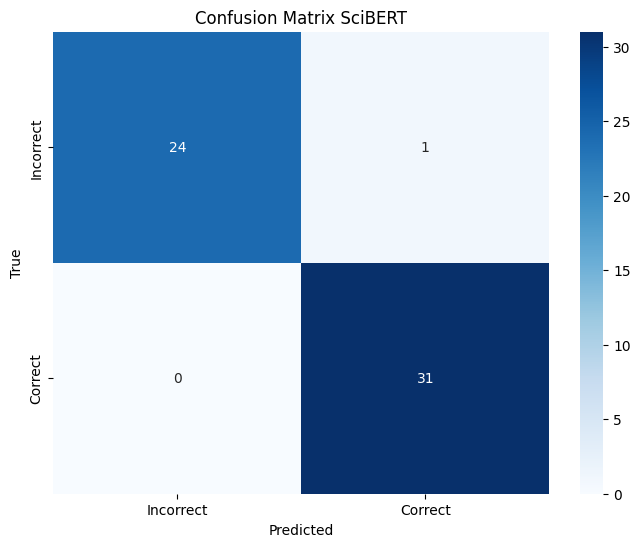

In [34]:
# Flatten the nested lists of predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(flat_predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(flat_true_labels, predicted_labels)
precision = precision_score(flat_true_labels, predicted_labels, average='weighted', zero_division=1)  # Set zero_division to 1
recall = recall_score(flat_true_labels, predicted_labels, average='weighted')
f1 = f1_score(flat_true_labels, predicted_labels, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix SciBERT')
plt.show()


In [35]:
import pandas as pd
import numpy as np

# Flatten the nested lists of predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(flat_predictions, axis=1)

# Ensure that the lengths match
min_length = min(len(flat_true_labels), len(predicted_labels), len(sentences))
flat_true_labels = flat_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]
sentences = sentences[:min_length]

# Create a DataFrame for misclassified sentences
misclassified_df = pd.DataFrame({
    'True Label': flat_true_labels,
    'Predicted Label': predicted_labels,
    'Sentence': sentences
})

# Filter the DataFrame to include only misclassified sentences
misclassified_df = misclassified_df[misclassified_df['True Label'] != misclassified_df['Predicted Label']]

# Set pandas options for better display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Assuming you have the misclassified DataFrame named misclassified_df

# Change labels for better readability
misclassified_df['True Label'] = np.where(misclassified_df['True Label'] == 1, 'Correct', 'Incorrect')
misclassified_df['Predicted Label'] = np.where(misclassified_df['Predicted Label'] == 1, 'Correct', 'Incorrect')

# Save the misclassified DataFrame to an Excel file
misclassified_df.to_excel("misclassified_sentences2.xlsx", index=False)

# Now, read the Excel file into a new DataFrame
misclassified_df_from_excel = pd.read_excel("misclassified_sentences2.xlsx")

misclassified_df_from_excel


,True Label,Predicted Label,Sentence
0,Incorrect,Correct,Methods: An anonymous Web-based survey was conducted with one thousand four hundred fifty-four 12- to 17-year-old youth.


In [39]:
import os
# Specify the directory where you want to save the model
output_dir = './trained_model_to_send/'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model to directory
model.save_pretrained(output_dir)

# Save tokenizer to directory
tokenizer.save_pretrained(output_dir)

# Save configuration to directory
model.config.save_pretrained(output_dir)

In [40]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
output_dir = './trained_model_to_send/'
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Input sentences for classification
sentences2 = ["The results show no effect", 
"The data showed that the there was a significant difference (p < 0.005) between the two groups",
 "The number of participants in the study was 95", "The study was performed on 75 students", 
 "The eventual sample size of the study is seventy-five", 
 "We recruited 27 male students and 28 female students (N=55)"]

# Tokenize input sentences
tokenized_input = tokenizer(sentences2, padding=True, truncation=True, return_tensors="pt")

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    # Forward pass
    outputs = model(**tokenized_input)

# Get the predicted probabilities
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (0 or 1 in binary classification)
predicted_class = torch.argmax(probs, dim=1).tolist()

# Display results
for sentence, label in zip(sentences2, predicted_class):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print()
    
    
#1 is correct 0 is incorrect

OSError: Incorrect path_or_model_id: './trained_model_to_send/'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

file_path = "Other_papers.xlsx"

df = pd.read_excel(file_path)
label_mapping = {'Non N-Value': 0, 'N-Value': 1}
df['Label'] = df['Label'].replace(label_mapping)

def classifier_scibert(sentence):
    output_dir = 'ClassifierToSend/trained_model_to_send/'
    model = BertForSequenceClassification.from_pretrained(output_dir)
    tokenizer = BertTokenizer.from_pretrained(output_dir)

    # Tokenize input sentences
    tokenized_input = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")

    # Ensure the model is in evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        # Forward pass
        outputs = model(**tokenized_input)

    # Get the predicted probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted class (0 or 1 in binary classification)
    predicted_class = torch.argmax(probs, dim=1).tolist()

    # Display results
    #print(f"Sentence: {sentence}")
    #print(f"Predicted Label: {predicted_class[0]}")
    #print()
    return predicted_class[0]


# Initialize an empty list to store classification results
classification_results = []

# Loop through each row in the 'Sentence' column
for sentence in df['Sentence']:
    # Get the classification result for the current sentence
    result = classifier_scibert(sentence)
    # Append the result to the list
    classification_results.append(result)

# Assign the list of results to the 'Classification' column of the DataFrame
df['Classification'] = classification_results

df

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

,Sentence,Label,doi,Classification
0,Citrulline and BEET are two of the most common...,0,https://doi.org/10.1080/19390211.2019.1650866,0
1,"Participants completed three return visits, se...",0,https://doi.org/10.1080/19390211.2019.1650866,1
2,Thirty subjects enrolled in the current study.,1,https://doi.org/10.1080/19390211.2019.1650866,1
3,"In total, 27 participants completed at least o...",1,https://doi.org/10.1080/19390211.2019.1650866,1
4,Recent studies have indicated that the mechani...,0,https://doi.org/10.3389/fphys.2017.00247,0
5,Fourteen healthy trained males took part in a ...,1,https://doi.org/10.3389/fphys.2017.00247,1
6,All 14 participants successfully completed the...,1,https://doi.org/10.3389/fphys.2017.00247,1
7,This result is also in agreement with previous...,0,https://doi.org/10.3389/fphys.2017.00247,0
8,Twenty participants undertook 7-d repeated bil...,1,https://doi.org/10.1080/02640414.2019.1664537,1
9,Participants performed a 5-min warm-up at 80 W...,0,https://doi.org/10.1080/02640414.2019.1664537,1


In [8]:
def calculate_accuracy(list1, list2):
    # Ensure both lists have the same length
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    # Count the number of matching elements
    matches = sum(el1 == el2 for el1, el2 in zip(list1, list2))
    
    # Calculate accuracy
    accuracy = matches / len(list1)
    
    return accuracy

accuracy = calculate_accuracy(df['Label'].tolist(), df['Classification'].tolist())
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [19]:
# 0 classifier_scibert('A second approach is to further recruit the computer’s potential for generating interactive feedback for learners.')
# 1 classifier_scibert('Two 6th-grade classes from a high SES school with the same science teacher participated.')
# 1 classifier_scibert('Logistical constraints required that the two classes be randomly assigned intact to either the TA condition (n = 28) or the Inspiration condition (n = 30).')
# 0 classifier_scibert('There was a main effect for time, indicating that students improved; F(3, 49) = 76.4, p < .001.')
# 1 classifier_scibert('Not all people participated')
classifier_scibert('Half of the participants were male.')


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


1